### References

[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Understanding Gated Recurrent Unit (GRU) in Deep Learning](https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2)

[What is LSTM - Long Short Term Memory?](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)

### Introduction

**a. Tasks for which Recurrent Neural Networks (RNNs) are useful:**


Recurrent Neural Networks are designed for **sequential data**, where current input depends on previous ones. Common applications include:

- **Natural Language Processing**: text generation, translation, sentiment analysis  
- **Speech Recognition**: converting audio to text  
- **Time Series Forecasting**: stock prices, weather data  
- **Video Captioning and Recognition**  
- **Music Generation**  
- **Anomaly Detection in Logs/Sensors**

---

**b. Examples of Problem Formulations**

| Formulation     | Input                         | Output                         | Example                          |
|-----------------|-------------------------------|--------------------------------|----------------------------------|
| One-to-Many     | Single input                  | Sequence output                | Image → Caption                  |
| Many-to-One     | Sequence input                | Single output                  | Sentence → Sentiment             |
| Many-to-Many    | Sequence input                | Sequence output                | English sentence → French sentence |



---

**c. RNN Model Processing the Word “Hello”**

Each character of "Hello" is input one-by-one. The hidden state is updated at each step. Only the final output is used for classification (e.g., predicting the language of the word).

**Model Components:**

- **Input (`x_t`)**: one-hot encoded or embedded character vector  
- **Embedding size**: e.g., 10  
- **Hidden state size**: e.g., 8  
- **Initial hidden state (`h₀`)**: zero vector  
- **RNN Cell**: applies transformation using `h_t = tanh(Wx_t + Uh_{t-1} + b)`  
- **Final output**: class label (language)

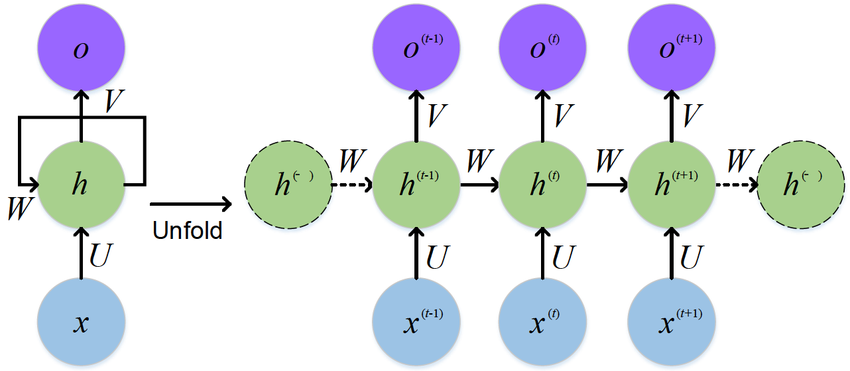

In [ ]:
from IPython.display import Image
Image(path + 'RNN.png', width=700, height=300)

---

**d. Main Differences: Vanilla RNN vs LSTM vs GRU**

| Feature         | Vanilla RNN             | LSTM (Long Short-Term Memory)       | GRU (Gated Recurrent Unit)        |
|-----------------|-------------------------|-------------------------------------|-----------------------------------|
| **Memory**      | Short-term only         | Long and short-term memory          | Similar to LSTM but simpler       |
| **Vanishing Gradients** | Prone         | Mitigated via gates                 | Mitigated via gates               |
| **Gates**       | None                    | Input, Forget, Output gates         | Update and Reset gates            |
| **Complexity**  | Simple                  | High                                | Moderate                          |

---

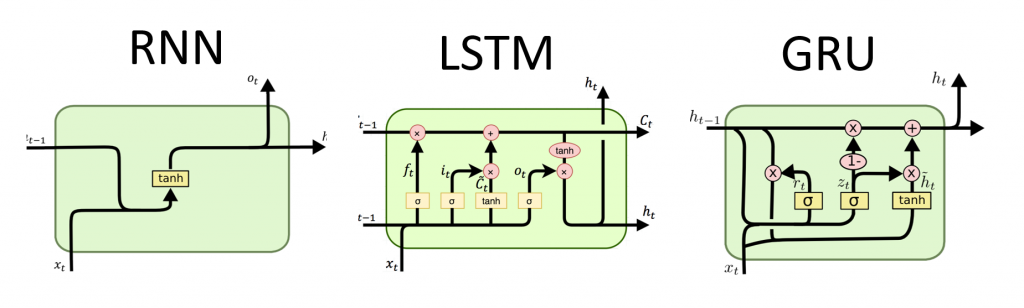

In [ ]:
from IPython.display import Image
Image(path + 'All.png', width=1000, height=400)

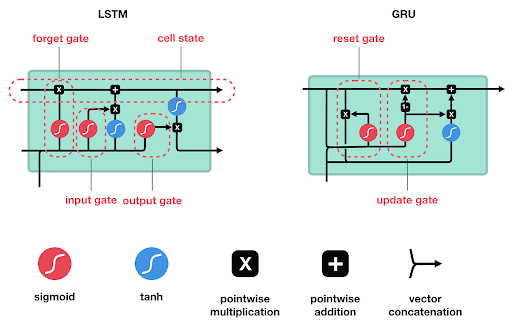

In [ ]:
from IPython.display import Image
Image(path + 'LSTM_GRU.png', width=600, height=400)

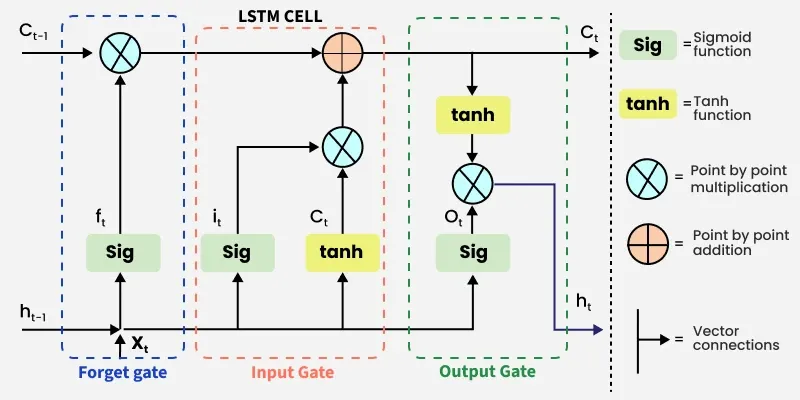

In [ ]:
from IPython.display import Image
Image(path + 'LSTM.png', width=600, height=300)

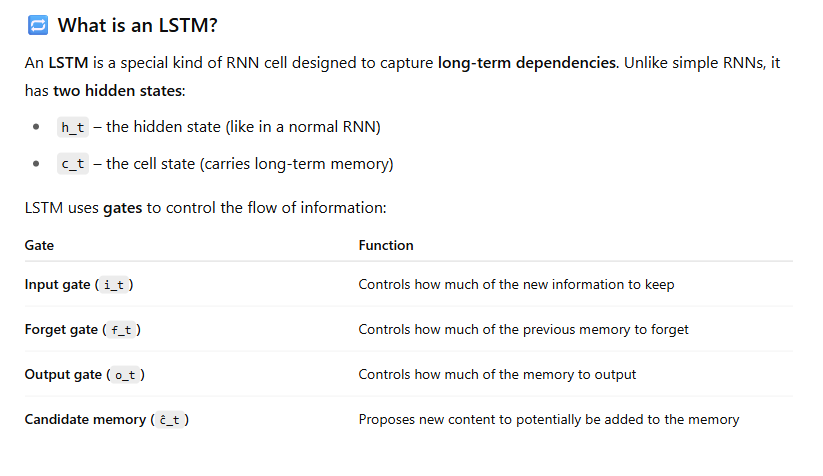

In [ ]:
from IPython.display import Image
Image(path + 'LSTM_expl.png', width=800, height=500)

### Import

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from collections import Counter

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from umap import UMAP
from matplotlib.lines import Line2D

### Data Analysis

In [228]:
path = './drive/MyDrive/IPYNB/S21/data/ML_10/'

df = pd.read_csv(path + 'babynames-clean.csv')

In [229]:
df = df.rename(columns={'John': 'Name', 'boy': 'Gender'})

In [230]:
df['NameLength'] = df['Name'].apply(len)

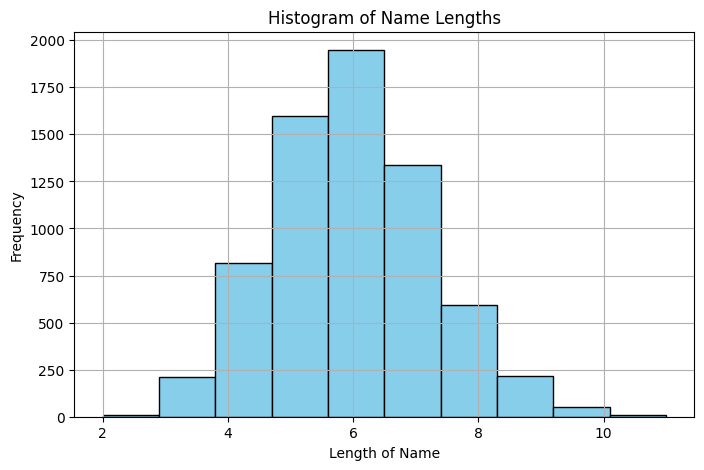

In [231]:
plt.figure(figsize=(8, 5))
plt.hist(df['NameLength'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Name Lengths')
plt.xlabel('Length of Name')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Balance ratio: 0.97


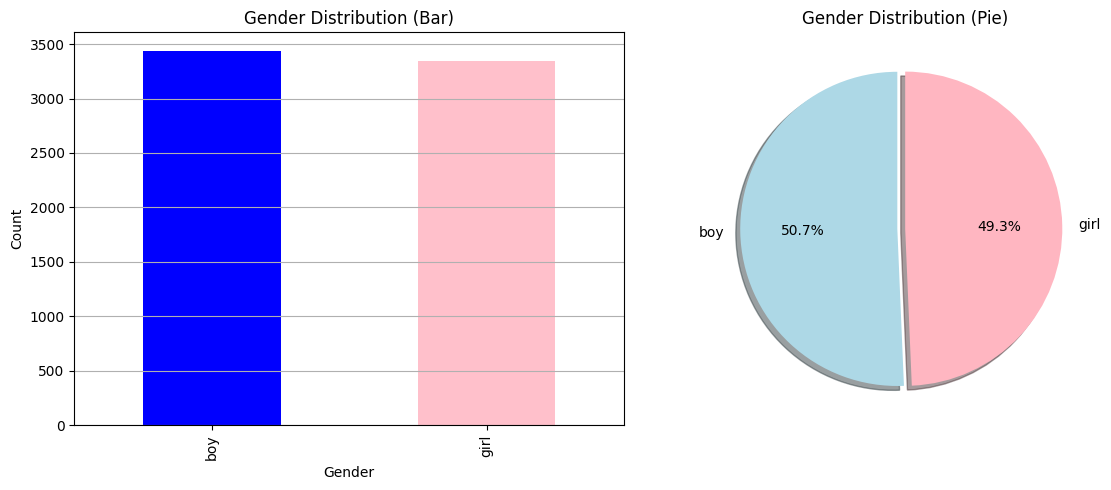

In [232]:
gender_counts = df['Gender'].value_counts()

balance_ratio = gender_counts.min() / gender_counts.max()
print(f"Balance ratio: {balance_ratio:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

gender_counts.plot(kind='bar',
                   color=['blue', 'pink'],
                   ax=axes[0])
axes[0].set_title('Gender Distribution (Bar)')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(gender_counts.index)
axes[0].grid(axis='y')

gender_counts.plot(kind='pie',
                   autopct='%1.1f%%',
                   colors=['lightblue', 'lightpink'],
                   startangle=90,
                   explode=(0.05, 0),
                   shadow=True,
                   ax=axes[1])
axes[1].set_title('Gender Distribution (Pie)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

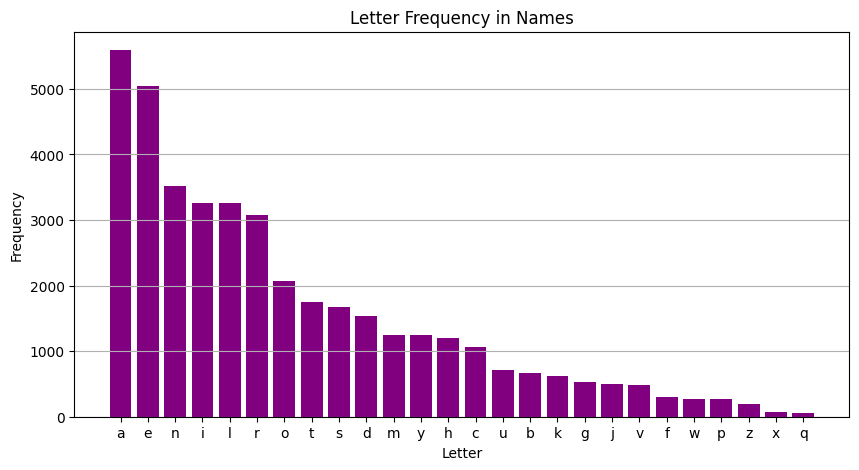

In [233]:
from collections import Counter

all_letters = ''.join(df['Name'].str.lower())
letter_counts = Counter(all_letters)
letter_df = pd.DataFrame(letter_counts.items(), columns=['Letter', 'Frequency']).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(letter_df['Letter'], letter_df['Frequency'], color='purple')
plt.title('Letter Frequency in Names')
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

### Data preparation

In [234]:
df['Gender'] = df['Gender'].map({'boy': 0, 'girl': 1})
df['Name'] = df['Name'].str.lower()

df['Processed'] = df['Name'].apply(lambda x: ['<SOS>'] + list(x) + ['<EOS>'])

max_len = df['Processed'].apply(len).max()
df['Padded'] = df['Processed'].apply(lambda x: x + [' '] * (max_len - len(x)))

token_set = set(token for name in df['Padded'] for token in name)
token_list = sorted(token_set)

token2id = {token: i for i, token in enumerate(token_list)}
id2token = {i: token for token, i in token2id.items()}

df['Encoded'] = df['Padded'].apply(lambda name: [token2id[token] for token in name])

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Train: 5424, Valid: 678, Test: 679


In [235]:
df.head()

,Name,Gender,NameLength,Processed,Padded,Encoded
0,william,0,7,"[<SOS>, w, i, l, l, i, a, m, <EOS>]","[<SOS>, w, i, l, l, i, a, m, <EOS>, , , , ]","[2, 25, 11, 14, 14, 11, 3, 15, 1, 0, 0, 0, 0]"
1,james,0,5,"[<SOS>, j, a, m, e, s, <EOS>]","[<SOS>, j, a, m, e, s, <EOS>, , , , , , ]","[2, 12, 3, 15, 7, 21, 1, 0, 0, 0, 0, 0, 0]"
2,charles,0,7,"[<SOS>, c, h, a, r, l, e, s, <EOS>]","[<SOS>, c, h, a, r, l, e, s, <EOS>, , , , ]","[2, 5, 10, 3, 20, 14, 7, 21, 1, 0, 0, 0, 0]"
3,george,0,6,"[<SOS>, g, e, o, r, g, e, <EOS>]","[<SOS>, g, e, o, r, g, e, <EOS>, , , , , ]","[2, 9, 7, 17, 20, 9, 7, 1, 0, 0, 0, 0, 0]"
4,frank,0,5,"[<SOS>, f, r, a, n, k, <EOS>]","[<SOS>, f, r, a, n, k, <EOS>, , , , , , ]","[2, 8, 20, 3, 16, 13, 1, 0, 0, 0, 0, 0, 0]"


In [236]:
class GenderTokenDataset(Dataset):
    def __init__(self, df):
        self.sequences = df['Encoded'].tolist()
        self.labels = df['Gender'].tolist()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        input_seq = torch.tensor(seq[:-1], dtype=torch.long)
        target_seq = torch.tensor(seq[1:], dtype=torch.long)
        gender_label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_seq, target_seq, gender_label

In [237]:
train_dataset = GenderTokenDataset(train_df)
valid_dataset = GenderTokenDataset(valid_df)
test_dataset = GenderTokenDataset(test_df)

In [238]:
vocab_size = len(token2id)
embed_dim = 32
hidden_size = 128

### Support functions

In [160]:
def train_model(model, train_dataset, valid_dataset, vocab_size, loss_type, num_epochs=30, batch_size=128, token_loss_weight=1.0, gender_loss_weight=0.5):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)

  criterion_token = nn.CrossEntropyLoss()
  criterion_gender = nn.BCELoss() if loss_type == 'bce' else nn.NLLLoss()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

  train_losses, valid_losses = [], []

  try:
    for epoch in range(num_epochs):
      # ---------- Training ----------
      model.train()
      total_train_loss = 0

      for input_tensor, target_tensor, gender_labels in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        gender_labels = gender_labels.to(device)

        token_logits, gender_probs, _ = model(input_tensor)  # (B, T, V), (B, 1), h_t
        logits = token_logits.view(-1, vocab_size)
        targets = target_tensor.view(-1)

        token_loss = criterion_token(logits, targets)

        if loss_type == 'bce':
          gender_loss = criterion_gender(gender_probs[:, 1].squeeze(), gender_labels.float())
        elif loss_type == 'nll':
          log_probs = F.log_softmax(gender_probs, dim=1)
          gender_loss = criterion_gender(log_probs, gender_labels.long())

        loss = token_loss_weight * token_loss + gender_loss_weight * gender_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # ---------- Validation ----------
      model.eval()
      total_valid_loss = 0
      with torch.no_grad():
        for input_tensor, target_tensor, gender_labels in valid_loader:
          input_tensor = input_tensor.to(device)
          target_tensor = target_tensor.to(device)
          gender_labels = gender_labels.to(device)

          token_logits, gender_probs, _ = model(input_tensor)
          logits = token_logits.view(-1, vocab_size)
          targets = target_tensor.view(-1)

          token_loss = criterion_token(logits, targets)

          if loss_type == 'bce':
            gender_loss = criterion_gender(gender_probs[:, 1].squeeze(), gender_labels.float())
          elif loss_type == 'nll':
            log_probs = F.log_softmax(gender_probs, dim=1)
            gender_loss = criterion_gender(log_probs, gender_labels.long())

          loss = token_loss_weight * token_loss + gender_loss_weight * gender_loss
          total_valid_loss += loss.item()

      avg_valid_loss = total_valid_loss / len(valid_loader)
      valid_losses.append(avg_valid_loss)

      scheduler.step(avg_valid_loss)

      # print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}")

  except KeyboardInterrupt:
    print("Training interrupted.")

  return train_losses, valid_losses

In [53]:
def plot_loss(model, train_losses, valid_losses):
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label='Train Loss', marker='*')
  plt.plot(valid_losses, label='Validation Loss', marker='|')
  plt.title(f'{model.__class__.__name__} Loss Convergence')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-Entropy Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def plot_loss_comparison(model, train_bce, val_bce, train_nll, val_nll):
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # BCE Loss Plot
  axes[0].plot(train_bce, label='Train Loss (BCE)', marker='*')
  axes[0].plot(val_bce, label='Validation Loss (BCE)', marker='|')
  axes[0].set_title(f'{model.__class__.__name__} - BCE Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  # NLL Loss Plot
  axes[1].plot(train_nll, label='Train Loss (NLL)', marker='*')
  axes[1].plot(val_nll, label='Validation Loss (NLL)', marker='|')
  axes[1].set_title(f'{model.__class__.__name__} - NLL Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].legend()
  axes[1].grid(True)

  plt.suptitle(f'{model.__class__.__name__} Loss Convergence Comparison', fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

In [54]:
def generate_name(model, token2id, id2token, start_seq=['<SOS>'], max_len=20, temperature=1.0, device='cpu'):
    model.eval()

    input_tokens_ids = [token2id[t] for t in start_seq]
    input_token_id = torch.tensor([[input_tokens_ids[0]]], dtype=torch.long).to(device)
    hidden_state = model.init_hidden(batch_size=1, device=device)

    # Initialize the output name with all tokens in start_seq except <SOS>
    name = start_seq[1:]

    with torch.no_grad():
      for t in range(len(start_seq)):
        token_logits, _, hidden_state = model(input_token_id, hidden_state)
        if t + 1 < len(start_seq):
          input_token_id = torch.tensor([[input_tokens_ids[t+1]]], dtype=torch.long).to(device)

      for _ in range(max_len - len(start_seq)):
        # Get model output for current input and hidden state
        token_logits, _, hidden_state = model(input_token_id, hidden_state)

        # Extract the logits for the last time step (the new predicted token)
        last_logits = token_logits[0, -1] # Shape: (vocab_size,)

        # Apply softmax with temperature to get probabilities
        probs = F.softmax(last_logits / temperature, dim=-1)

        # Sample the next token ID from the probability distribution
        token_id = torch.multinomial(probs, num_samples=1).item()

        if token_id == token2id['<EOS>']:
          break

        # Convert token ID to character and add to generated name
        name.append(id2token[token_id])

        # Prepare input for next time step (the token just generated)
        input_token_id = torch.tensor([[token_id]], dtype=torch.long).to(device)

    return ''.join(name)

In [55]:
def evaluate_gender_auc(model, test_dataset, batch_size, loss_type, device):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
      for input_tensor, _, gender_label in test_loader:
        input_tensor = input_tensor.to(device)
        gender_label = gender_label.to(device)

        _, gender_probs, _ = model(input_tensor)
        if loss_type == 'bce':
          probs = gender_probs[:, 1]
        else:
          probs = F.softmax(gender_probs, dim=1)[:, 1]

        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(gender_label.cpu().numpy())

    auc = roc_auc_score(all_labels, all_preds)
    print(f"Test ROC AUC for Gender Prediction ({loss_type.upper()} Loss): {auc:.4f}")

### Recurrent Neural Network

In [220]:
class VanillaRNNBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
      super().__init__()
      self.W_ih = nn.Linear(input_size, hidden_size)
      self.W_hh = nn.Linear(hidden_size, hidden_size)
      self.tanh = nn.Tanh()

    def forward(self, x_t, h_prev):
      h_t = self.tanh(self.W_ih(x_t) + self.W_hh(h_prev))
      return h_t

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_cell = VanillaRNNBlock(embed_dim, hidden_size)
        self.token_decoder = nn.Linear(hidden_size, vocab_size) # Predicts the next token at each timestep (for token-level generation)
        self.gender_decoder = nn.Linear(hidden_size, 2)         # Takes the final hidden state and predicts gender (binary output)
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()

    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size, device=device)

    def forward(self, input_seq, hidden=None):
        batch_size, seq_len = input_seq.size()
        embedded = self.embedding(input_seq) # (B, T, E)

        if hidden is None:
            h_t = self.init_hidden(batch_size, device=input_seq.device)
        else:
            h_t = hidden

        outputs = []
        for t in range(seq_len):
          x_t = embedded[:, t, :]
          h_t = self.rnn_cell(x_t, h_t)
          h_drop = self.dropout(h_t)
          token_logits = self.token_decoder(h_drop)
          outputs.append(token_logits)

        token_logits = torch.stack(outputs, dim=1)  # (B, T, V)
        gender_logit = self.gender_decoder(h_t)    # (B, 2)
        gender_prob = self.sigmoid(gender_logit)

        return token_logits, gender_prob, h_t

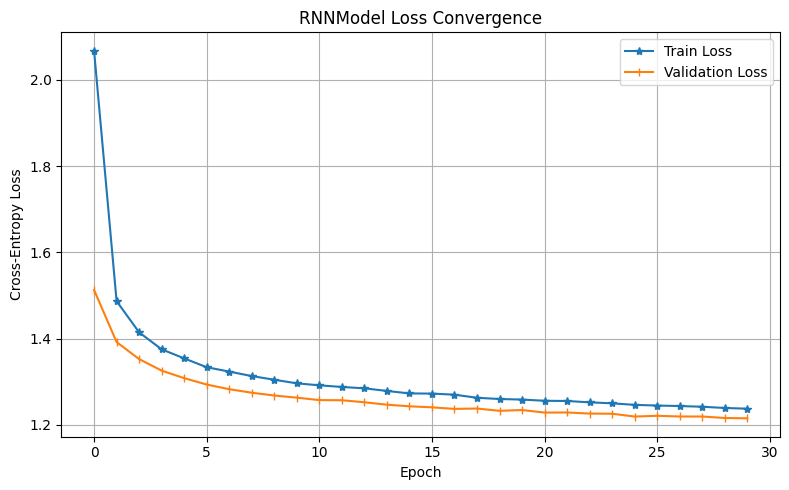

In [221]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RNN = RNNModel(vocab_size=vocab_size, embed_dim=32, hidden_size=128, dropout=0.5).to(device)
train_losses, valid_losses = train_model(RNN, train_dataset, valid_dataset, vocab_size, loss_type='bce',
                                         num_epochs=30, batch_size=128, gender_loss_weight=0.0)
plot_loss(RNN, train_losses, valid_losses)

In [239]:
for _ in range(10):
  print(generate_name(RNN, token2id, id2token, device=device).capitalize())

Ariymh
Amika
Itia
Ayle
Ileire
Amen
Licnelki
Rorus
Ielan
Awisa


In [226]:
evaluate_gender_auc(RNN, test_dataset, batch_size=128, device=device, loss_type='CE')

Test ROC AUC for Gender Prediction (CE Loss): 0.5000


### Example

In [118]:
train_df.head(3)

,Name,Gender,NameLength,Processed,Padded,Encoded
2770,demarco,0,7,"[<SOS>, d, e, m, a, r, c, o, <EOS>]","[<SOS>, d, e, m, a, r, c, o, <EOS>, , , , ]","[2, 6, 7, 15, 3, 20, 5, 17, 1, 0, 0, 0, 0]"
6042,fallon,1,6,"[<SOS>, f, a, l, l, o, n, <EOS>]","[<SOS>, f, a, l, l, o, n, <EOS>, , , , , ]","[2, 8, 3, 14, 14, 17, 16, 1, 0, 0, 0, 0, 0]"
453,mat,0,3,"[<SOS>, m, a, t, <EOS>]","[<SOS>, m, a, t, <EOS>, , , , , , , , ]","[2, 15, 3, 22, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [119]:
input_tensor = torch.tensor(train_df['Encoded'][0:3].tolist(), dtype=torch.long)
print(input_tensor.shape)
input_tensor

torch.Size([3, 13])


tensor([[ 2,  6,  7, 15,  3, 20,  5, 17,  1,  0,  0,  0,  0],
        [ 2,  8,  3, 14, 14, 17, 16,  1,  0,  0,  0,  0,  0],
        [ 2, 15,  3, 22,  1,  0,  0,  0,  0,  0,  0,  0,  0]])

In [120]:
model = RNNModel(vocab_size=len(token2id), embed_dim=32, hidden_size=64)

In [121]:
token_embedding = model.embedding(input_tensor)
print(token_embedding.shape)
token_embedding

torch.Size([3, 13, 32])


tensor([[[-2.2108,  0.3278, -0.6775,  ...,  1.2462, -0.6035, -0.2429],
         [ 1.1244,  0.7068,  0.1723,  ...,  0.1902, -0.2374,  1.4427],
         [ 2.7623,  0.7847, -0.6946,  ..., -1.1846,  0.5914,  0.4450],
         ...,
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543],
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543],
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543]],

        [[-2.2108,  0.3278, -0.6775,  ...,  1.2462, -0.6035, -0.2429],
         [ 0.2199,  0.0791, -0.0343,  ...,  0.0633, -1.4287,  0.6194],
         [-0.3771,  0.9956, -0.2357,  ..., -0.3543,  0.1248, -0.5506],
         ...,
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543],
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543],
         [ 0.9359, -0.4113, -1.0227,  ..., -0.5929,  0.4917,  0.7543]],

        [[-2.2108,  0.3278, -0.6775,  ...,  1.2462, -0.6035, -0.2429],
         [-0.9421,  0.3314, -0.0710,  ...,  0

In [122]:
h_t = torch.zeros((3, model.hidden_size), device=input_tensor.device)
print(h_t.shape)
h_t

torch.Size([3, 64])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [123]:
batch_size, seq_len, embed_dim = token_embedding.shape

outputs = []

for t in range(seq_len):
    x_t = token_embedding[:, t, :]
    print(f"Time step {t+1}")
    print(f"Input x_t:\n{x_t}")

    h_t = model.rnn_cell(x_t, h_t)
    print(f"Updated hidden state h_t:\n{h_t}")

    h_drop = model.dropout(h_t)

    # Compute logits for the next token
    logits = model.token_decoder(h_drop)
    print(f"Logits for next token:\n{logits}")

    outputs.append(logits)
    if t == 1:
      break

token_logits = torch.stack(outputs, dim=1)
gender_logits = model.gender_decoder(h_t)

Time step 1
Input x_t:
tensor([[-2.2108,  0.3278, -0.6775, -0.3834, -0.1067, -0.1328,  1.6788, -1.1432,
          0.4455,  0.8652, -0.0897, -0.5490,  0.4505, -1.1690, -2.3451, -1.0676,
          0.3759,  0.3255, -1.2878, -0.9776,  0.9718,  1.0745,  0.7616,  0.1581,
         -1.4900, -0.2736,  0.7809,  0.7756,  0.4853,  1.2462, -0.6035, -0.2429],
        [-2.2108,  0.3278, -0.6775, -0.3834, -0.1067, -0.1328,  1.6788, -1.1432,
          0.4455,  0.8652, -0.0897, -0.5490,  0.4505, -1.1690, -2.3451, -1.0676,
          0.3759,  0.3255, -1.2878, -0.9776,  0.9718,  1.0745,  0.7616,  0.1581,
         -1.4900, -0.2736,  0.7809,  0.7756,  0.4853,  1.2462, -0.6035, -0.2429],
        [-2.2108,  0.3278, -0.6775, -0.3834, -0.1067, -0.1328,  1.6788, -1.1432,
          0.4455,  0.8652, -0.0897, -0.5490,  0.4505, -1.1690, -2.3451, -1.0676,
          0.3759,  0.3255, -1.2878, -0.9776,  0.9718,  1.0745,  0.7616,  0.1581,
         -1.4900, -0.2736,  0.7809,  0.7756,  0.4853,  1.2462, -0.6035, -0.2429]],
 

In [124]:
token_logits.size()

torch.Size([3, 2, 29])

In [125]:
token_logits

tensor([[[ 2.7862e-01,  2.7678e-01, -6.8615e-02,  1.5105e-01, -1.1695e-01,
           9.9873e-02,  3.6785e-01, -2.8423e-01,  5.0940e-01,  5.6009e-01,
          -1.4321e-01,  4.9506e-01, -5.5215e-01,  2.9876e-01, -5.6740e-01,
          -2.9086e-01, -1.5999e-01, -1.8631e-01, -3.6527e-01, -1.8922e-01,
          -3.4748e-01, -1.4127e-02, -1.4288e-01, -4.3858e-01, -6.4380e-02,
           8.5950e-01,  1.6557e-01,  3.4391e-01, -1.1301e-02],
         [ 1.5831e-02, -7.1882e-02, -5.2708e-01, -4.6308e-02,  2.2510e-02,
           1.7905e-01,  5.3441e-01, -5.8379e-01,  2.2637e-01,  2.9166e-01,
          -9.7789e-02, -1.2268e-01,  5.5072e-02,  8.1478e-02,  1.7965e-01,
           2.0378e-01, -2.9714e-01, -8.0732e-02, -2.5003e-01, -2.6054e-01,
           1.1250e-02,  5.2804e-02, -1.0277e-01, -2.8850e-01, -8.0684e-04,
           4.7392e-01, -2.8680e-01,  1.2052e-02, -6.1077e-02]],

        [[ 1.4806e-01, -1.9882e-02, -1.0120e-01, -1.4407e-01,  1.7006e-01,
           1.3093e-01,  1.3835e-01,  4.0799e-02

In [126]:
print("Predicted next token:", id2token[token_logits[0, 0].argmax().item()])

Predicted next token: w


In [127]:
gender_logits

tensor([[ 0.0391, -0.0209],
        [ 0.3861, -0.4727],
        [-0.3958,  0.3728]], grad_fn=<AddmmBackward0>)

In [128]:
gender_probs = F.sigmoid(gender_logits)

In [129]:
gender_probs

tensor([[0.5098, 0.4948],
        [0.5954, 0.3840],
        [0.4023, 0.5921]], grad_fn=<SigmoidBackward0>)

### Gated Recurrent Unit

In [240]:
class GRUBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        # Update gate: decides how much of the previous hidden state to keep
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)

        # Reset gate: controls how much past information to forget
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)

        # Candidate hidden state: potential new memory content
        self.W_h = nn.Linear(input_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x_t, h_prev):
        z_t = torch.sigmoid(self.W_z(x_t) + self.U_z(h_prev))
        r_t = torch.sigmoid(self.W_r(x_t) + self.U_r(h_prev))
        h_hat = torch.tanh(self.W_h(x_t) + self.U_h(r_t * h_prev)) # Compute candidate hidden state using reset-modified h_prev
        h_t = (1 - z_t) * h_prev + z_t * h_hat # Final hidden state: blend between h_prev and candidate h_hat
        return h_t

class GRUModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, dropout=0.1):
      super().__init__()
      self.hidden_size = hidden_size
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      self.rnn_cell = GRUBlock(embed_dim, hidden_size)
      self.token_decoder = nn.Linear(hidden_size, vocab_size)
      self.gender_decoder = nn.Linear(hidden_size, 2)
      self.dropout = nn.Dropout(dropout)
      self.sigmoid = nn.Sigmoid()

  def init_hidden(self, batch_size, device):
      return torch.zeros(batch_size, self.hidden_size, device=device)

  def forward(self, input_seq, hidden=None):
      batch_size, seq_len = input_seq.size()
      embedded = self.embedding(input_seq)

      if hidden is None:
          h_t = self.init_hidden(batch_size, input_seq.device)
      else:
          h_t = hidden

      outputs = []
      for t in range(seq_len):
        x_t = embedded[:, t, :]
        h_t = self.rnn_cell(x_t, h_t)
        h_drop = self.dropout(h_t)
        logits = self.token_decoder(h_drop)
        outputs.append(logits)

      token_logits = torch.stack(outputs, dim=1)  # (B, T, V)
      gender_logit = self.gender_decoder(h_t)     # (B, 2)
      gender_prob = self.sigmoid(gender_logit)

      return token_logits, gender_prob, h_t

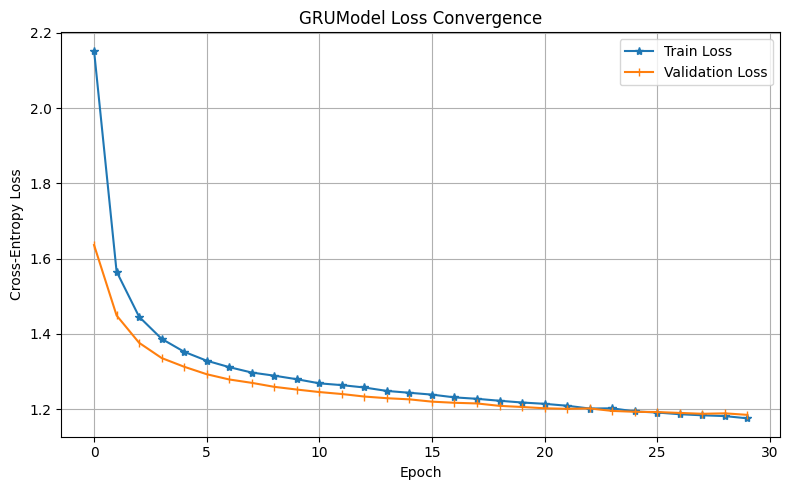

In [241]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRU = GRUModel(vocab_size=vocab_size, embed_dim=32, hidden_size=128, dropout=0.5).to(device)
train_losses, valid_losses = train_model(GRU, train_dataset, valid_dataset, vocab_size, loss_type='bce',
                                         num_epochs=30, batch_size=128, gender_loss_weight=0.0)
plot_loss(GRU, train_losses, valid_losses)

In [242]:
for _ in range(10):
  print(generate_name(GRU, token2id, id2token, device=device).capitalize())

Ade
Ricki
Orge
Arlee
Cligt
Evic
Elleon
Maretta
Hotal
Elsei


In [244]:
evaluate_gender_auc(GRU, test_dataset, batch_size=128, device=device, loss_type='CE')

Test ROC AUC for Gender Prediction (CE Loss): 0.5000


### Long Short-Term Memory

In [245]:
class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
      super().__init__()
      self.hidden_size = hidden_size

      # Input gate
      self.W_i = nn.Linear(input_size, hidden_size)
      self.U_i = nn.Linear(hidden_size, hidden_size)

      # Forget gate
      self.W_f = nn.Linear(input_size, hidden_size)
      self.U_f = nn.Linear(hidden_size, hidden_size)

      # Output gate
      self.W_o = nn.Linear(input_size, hidden_size)
      self.U_o = nn.Linear(hidden_size, hidden_size)

      # Candidate memory cell
      self.W_c = nn.Linear(input_size, hidden_size)
      self.U_c = nn.Linear(hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
      i_t = torch.sigmoid(self.W_i(x_t) + self.U_i(h_prev)) # Controls how much new information to write into memory.
      f_t = torch.sigmoid(self.W_f(x_t) + self.U_f(h_prev)) # Controls how much of the old memory (c_prev) to forget.
      o_t = torch.sigmoid(self.W_o(x_t) + self.U_o(h_prev)) # Controls how much memory content is exposed as output.
      c_hat_t = torch.tanh(self.W_c(x_t) + self.U_c(h_prev)) # Proposes new memory content to potentially store in cell state.

      c_t = f_t * c_prev + i_t * c_hat_t # f_t * c_prev: retain part of the previous memory, i_t * c_hat_t: add new candidate info
      h_t = o_t * torch.tanh(c_t) # The hidden state is a gated version of the new memory.

      return h_t, c_t

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, dropout=0.1):
      super().__init__()
      self.hidden_size = hidden_size
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      self.lstm_cell = LSTMBlock(embed_dim, hidden_size)
      self.token_decoder = nn.Linear(hidden_size, vocab_size)
      self.gender_decoder = nn.Linear(hidden_size, 2)
      self.dropout = nn.Dropout(dropout)
      self.sigmoid = nn.Sigmoid()

    def init_hidden(self, batch_size, device):
      h_0 = torch.zeros(batch_size, self.hidden_size, device=device)
      c_0 = torch.zeros(batch_size, self.hidden_size, device=device)
      return h_0, c_0

    def forward(self, input_seq, hidden=None):
      batch_size, seq_len = input_seq.size()
      embedded = self.embedding(input_seq) # (B, T, E)

      if hidden is None:
        h_t, c_t = self.init_hidden(batch_size, input_seq.device)
      else:
        h_t, c_t = hidden

      outputs = []
      for t in range(seq_len):
        x_t = embedded[:, t, :] # (B, E)
        h_t, c_t = self.lstm_cell(x_t, h_t, c_t) # (B, H), (B, H)
        h_drop = self.dropout(h_t)
        logits = self.token_decoder(h_drop) # (B, V)
        outputs.append(logits)

      token_logits = torch.stack(outputs, dim=1)  # (B, T, V)
      gender_logit = self.gender_decoder(h_t)     # (B, 2)
      gender_probs = self.sigmoid(gender_logit)

      return token_logits, gender_probs, (h_t, c_t)

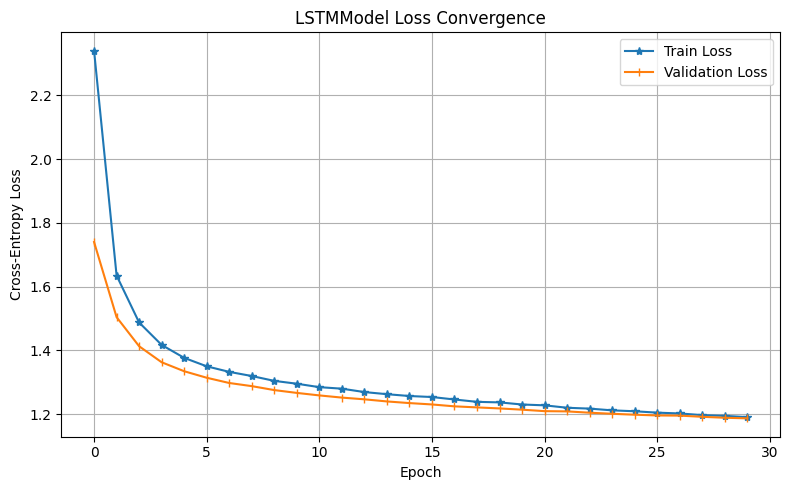

In [246]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LSTM = LSTMModel(vocab_size=vocab_size, embed_dim=32, hidden_size=128, dropout=0.5).to(device)
train_losses, valid_losses = train_model(LSTM, train_dataset, valid_dataset, vocab_size, loss_type='bce',
                                         num_epochs=30, batch_size=128, gender_loss_weight=0.0)
plot_loss(LSTM, train_losses, valid_losses)

In [251]:
for _ in range(10):
  print(generate_name(LSTM, token2id, id2token, device=device).capitalize())

Olary
Elnetio
Arleyna
Arlino
Reshas
Sandari
Keleda
Assin
Roida
Arlenne


In [250]:
evaluate_gender_auc(LSTM, test_dataset, batch_size=128, device=device, loss_type='CE')

Test ROC AUC for Gender Prediction (CE Loss): 0.5000


### Model comparison

**a. Propose your own metric for name generation**

**Average Edit Distance from Real Names**

- For each generated name, calculate the minimum **Levenshtein distance** to any real name in the dataset.
- Then take the average over all generated names.

Advantages:
- Measures similarity to real names.

- Penalizes gibberish outputs.

- Better than just checking letter-by-letter probabilities.

**b. What does perplexity measure?**

**Perplexity** is a commonly used metric in natural language processing (NLP) to evaluate how well a language model predicts a sample. It measures the uncertainty of a model when it makes predictions — lower perplexity means the model is more confident and performs better.


$$\text{Perplexity} = \exp(\frac{1}{N} \sum_{i=1}^N -\log p(x_i))$$


Where:

- $x_i$ is the true next token.
- $p(x_i)$ is the probability the model assigned to the correct token
- $N$ is the number of tokens

**c. How is related to cross-entropy?**

Perplexity is **exponential of average cross-entropy loss**:

$$\text{Cross Entropy} = -\frac{1}{N} \sum_{i=1}^N -\log p(x_i))$$


$$\text{Perplexity} = \exp (\text{Cross Entropy})$$

So, if cross entropy is low (model is confident and correct), perplexity is also low.

**d. Implement 2 versions of perplexity**

In [ ]:
# With CrossEntropyLoss
def perplexity_from_cross_entropy(logits, targets):
    # logits: (batch, seq_len, vocab_size)
    # targets: (batch, seq_len)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), reduction='mean')
    return torch.exp(loss)

# Without CrossEntropyLoss
def perplexity_manual(probabilities, targets):
    # probabilities: (batch, seq_len, vocab_size), already softmaxed
    # targets: (batch, seq_len)
    batch_size, seq_len = targets.shape
    probs = probabilities[torch.arange(batch_size).unsqueeze(1), torch.arange(seq_len), targets]
    log_probs = torch.log(probs + 1e-9)
    return torch.exp(-log_probs.mean())

**e. Value of perplexity for a random model**

A **random model** assigns uniform probability to each character in the vocabulary.

If the vocabulary size is `V`, then:

$$p(x_i) = (\frac{1}{V})$$

$$
\text{Cross Entropy} = -\log\left(\frac{1}{V}\right) = \log(V)
$$

$$
\text{Perplexity} = \exp(\log(V)) = V
$$


**So perplexity for a random model = vocabulary size (V)**

E.g., if 28 tokens (26 letters + `<SOS>` + `<EOS>`), then:

$$
\text{Perplexity} = 28
$$

**f. Perplexity for a "most popular letters" model**

This model always outputs a fixed probability distribution of character frequencies $p(c)$, based on training data.

Let’s define:

- True next token: $x_i$
- Model probability: $p(x_i) = \text{frequency}(x_i)$

Then:

$$
\text{Cross Entropy} = -\frac{1}{N} \sum_{i=1}^{N} \log p(x_i)
$$

$$
\text{Perplexity} = \exp\left(-\sum_x p_{\text{data}}(x) \log p_{\text{model}}(x)\right)
$$

This is equivalent to **KL divergence + entropy of the true distribution**, and if $p_{\text{model}} = p_{\text{data}}$, it's just:

$$
\text{Perplexity} = \exp(H(p))
$$

For example, if the entropy of the character distribution in data is approximately 3.2 bits:

$$
\text{Perplexity} = 2^{3.2} \approx 9.2
$$

So, this model should have perplexity **lower than random**, but **higher than a well-trained model**.


**g. Model Comparison Summary**

| Model                      | Description                                    | Expected Perplexity     |
|---------------------------|------------------------------------------------|--------------------------|
| Random                    | Uniform probabilities over letters             | ~Vocab Size (e.g., 28)   |
| Most popular letters      | Based on empirical frequency                   | ~9–10                    |
| Trained RNN / GRU / LSTM | Learns patterns in names                       | < 5 if trained well      |
| Oracle (true distribution)| Knows the actual next token distribution       | Best possible (< entropy)|

### Gender classification

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Test ROC AUC for Gender Prediction (BCE Loss): 0.9213
Test ROC AUC for Gender Prediction (NLL Loss): 0.9124


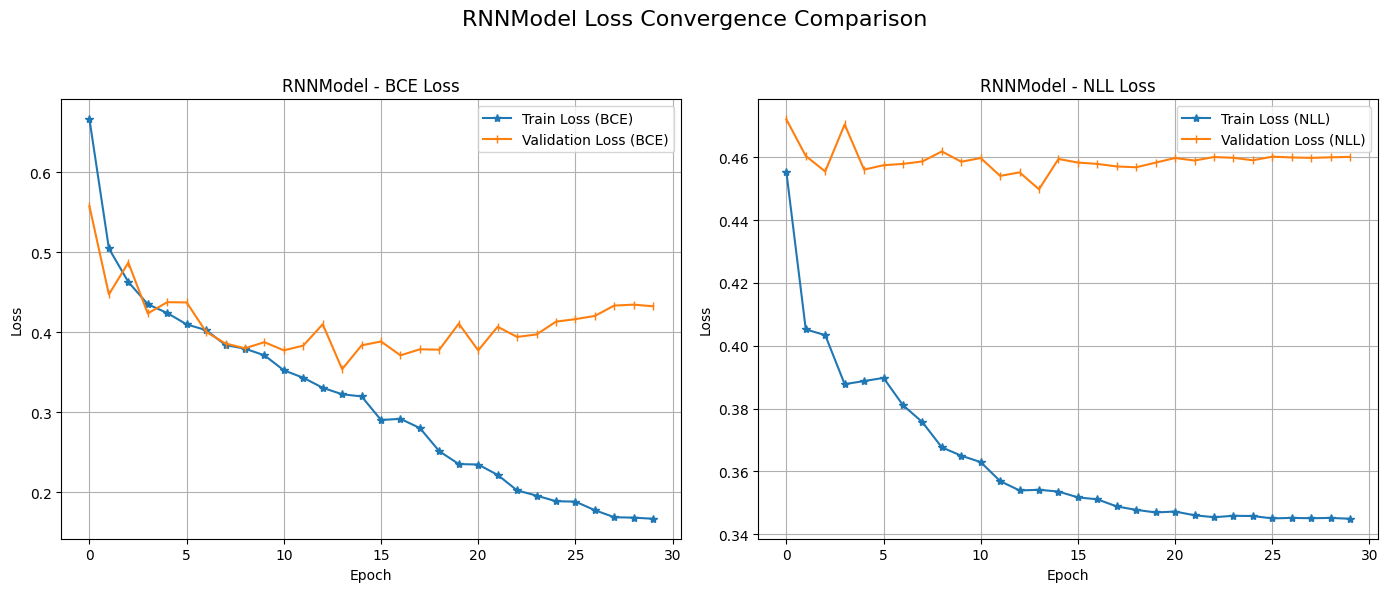

In [162]:
RNN = RNNModel(vocab_size=len(token2id), embed_dim=32, hidden_size=128, dropout=0.5).to(device)

train_bce, val_bce = train_model(RNN, train_dataset, valid_dataset, vocab_size, loss_type='bce', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(RNN, test_dataset, batch_size=128, loss_type='bce', device=device)

train_nll, val_nll = train_model(RNN, train_dataset, valid_dataset, vocab_size, loss_type='nll', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(RNN, test_dataset, batch_size=128, loss_type='nll', device=device)

plot_loss_comparison(RNN, train_bce, val_bce, train_nll, val_nll)

Test ROC AUC for Gender Prediction (BCE Loss): 0.9209
Test ROC AUC for Gender Prediction (NLL Loss): 0.9179


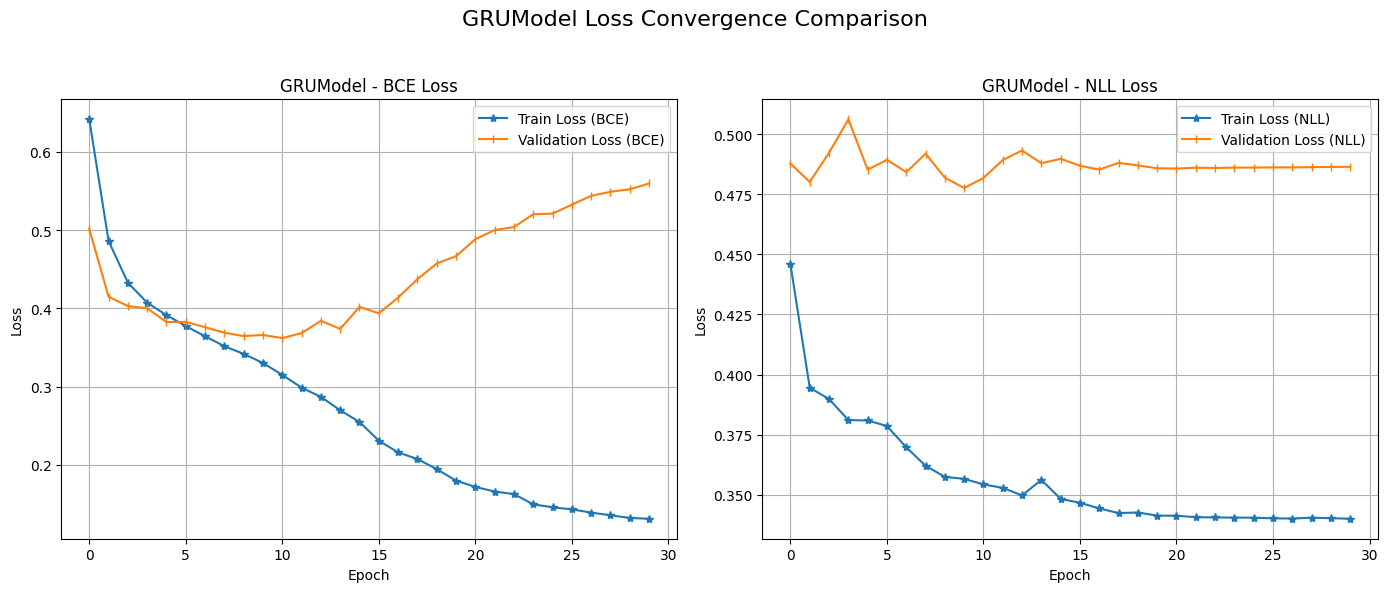

In [164]:
GRU = GRUModel(vocab_size=len(token2id), embed_dim=32, hidden_size=128, dropout=0.5).to(device)

train_bce, val_bce = train_model(GRU, train_dataset, valid_dataset, vocab_size, loss_type='bce', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(GRU, test_dataset, batch_size=128, loss_type='bce', device=device)

train_nll, val_nll = train_model(GRU, train_dataset, valid_dataset, vocab_size, loss_type='nll', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(GRU, test_dataset, batch_size=128, loss_type='nll', device=device)

plot_loss_comparison(GRU, train_bce, val_bce, train_nll, val_nll)

Test ROC AUC for Gender Prediction (BCE Loss): 0.9170
Test ROC AUC for Gender Prediction (NLL Loss): 0.9042


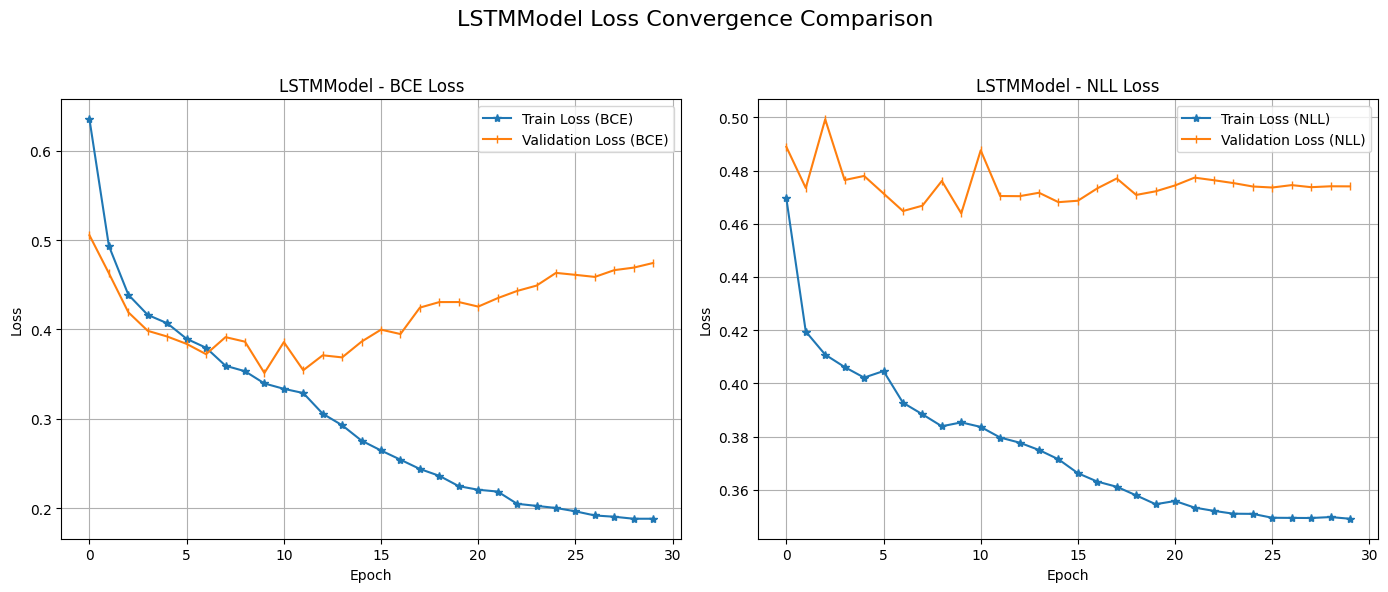

In [165]:
LSTM = LSTMModel(vocab_size=len(token2id), embed_dim=32, hidden_size=128, dropout=0.5).to(device)

train_bce, val_bce = train_model(LSTM, train_dataset, valid_dataset, vocab_size, loss_type='bce', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(LSTM, test_dataset, batch_size=128, loss_type='bce', device=device)

train_nll, val_nll = train_model(LSTM, train_dataset, valid_dataset, vocab_size, loss_type='nll', token_loss_weight=0.0, gender_loss_weight=1.0)
evaluate_gender_auc(LSTM, test_dataset, batch_size=128, loss_type='nll', device=device)

plot_loss_comparison(LSTM, train_bce, val_bce, train_nll, val_nll)

**Gender Classification Loss Comparison: BCE vs NLL**

We trained RNN, GRU, and LSTM models using two different loss functions:
- Binary Cross Entropy (BCE)
- Negative Log Likelihood (NLL)

Below are key observations from the training and validation loss convergence plots.

---

**RNNModel**
- BCE: Train loss decreases significantly (~0.13), but validation loss starts rising → overfitting.
- NLL: Train and validation losses are stable but flat → underfitting.

**GRUModel**
- BCE: Train loss drops sharply (~0.08), while validation loss rises after ~epoch 10 → strong overfitting.
- NLL: Slower convergence, stable validation loss around 0.48 → better generalization.

**LSTMModel**
- BCE: Similar pattern — low train loss, increasing validation loss → overfitting.
- NLL: Train loss around 0.33, validation loss very flat (~0.48) → limited learning.

---

**Conclusion**

- BCE is suitable when quick learning is needed, but requires early stopping or dropout to control overfitting.
- NLL provides more stable validation behavior and is safer for generalization, though it may underfit unless carefully tuned.


### Vanishing Gradient

In [167]:
mode_len = Counter(train_df['NameLength']).most_common(1)[0][0]
subset_df = train_df[train_df['NameLength'] == mode_len].reset_index(drop=True)

special_tokens = ['<SOS>', '<EOS>', ' ']
token_list = sorted(set(''.join(name for name in subset_df['Name'])))
token_list = special_tokens + token_list

token2id = {ch: i+1 for i, ch in enumerate(token_list)}
id2token = {i: ch for ch, i in token2id.items()}

subset_df['Processed'] = subset_df['Name'].apply(lambda x: ['<SOS>'] + list(x) + ['<EOS>'])

max_len = subset_df['Processed'].apply(len).max()

subset_df['Padded'] = subset_df['Processed'].apply(lambda x: x + [' '] * (max_len - len(x)))
subset_df['Encoded'] = subset_df['Padded'].apply(lambda name: [token2id[token] for token in name])

subset_dataset = GenderTokenDataset(subset_df)
subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False)
print(f"Subset size: {len(subset_loader)}")

vocab_size = len(token2id)
embedding_size = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Subset size: 1554


In [168]:
subset_df.head(3)

,Name,Gender,NameLength,Processed,Padded,Encoded
0,fallon,1,6,"[<SOS>, f, a, l, l, o, n, <EOS>]","[<SOS>, f, a, l, l, o, n, <EOS>]","[1, 9, 4, 15, 15, 18, 17, 2]"
1,armond,0,6,"[<SOS>, a, r, m, o, n, d, <EOS>]","[<SOS>, a, r, m, o, n, d, <EOS>]","[1, 4, 21, 16, 18, 17, 7, 2]"
2,werner,0,6,"[<SOS>, w, e, r, n, e, r, <EOS>]","[<SOS>, w, e, r, n, e, r, <EOS>]","[1, 26, 8, 21, 17, 8, 21, 2]"


In [177]:
def gradient_analysis(model, subset_loader, device, n_epochs, loss_type):
  collected_grads = []

  def save_gradients(module, grad_input, grad_output):
    if grad_output[0] is not None:
      collected_grads.append(grad_output[0].detach().cpu())

  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  hook_handle = model.embedding.register_full_backward_hook(save_gradients)
  frob_norms = []

  for epoch in range(n_epochs):
    collected_grads.clear()
    epoch_frobs = []

    for batch in subset_loader:
      if loss_type == 'gender':
        input_seq, _, gender_label = batch
        input_seq = input_seq.to(device)
        gender_label = gender_label.to(device)

        optimizer.zero_grad()
        _, gender_probs, _ = model(input_seq)
        loss = nn.BCELoss()(gender_probs[:, 1], gender_label.float())
        loss.backward()

      elif loss_type == 'next':
        input_seq, target_seq, _ = batch
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        optimizer.zero_grad()
        logits, _, _ = model(input_seq)  # (batch, seq_len, vocab_size)

        # Align for next-token prediction: predict t+1 from input at t
        logits = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
        targets = target_seq[:, 1:].contiguous().view(-1)

        loss = nn.CrossEntropyLoss()(logits, targets)
        loss.backward()
      else:
        raise ValueError("Invalid loss_type. Use 'gender' or 'next'.")

      optimizer.step()

      if not collected_grads:
        hook_handle.remove()
        raise RuntimeError("No gradients were collected")

      # Compute Frobenius norm per token
      grad_tensor = collected_grads[-1]  # Shape: (1, seq_len, embed_dim)
      frob = grad_tensor[0].norm(dim=-1)  # Shape: (seq_len,)
      epoch_frobs.append(frob.numpy())
      break  # Only 1 batch per epoch

    if epoch_frobs:
      epoch_frob_mean = np.mean(epoch_frobs, axis=0)  # shape: (seq_len,)
      frob_norms.append(epoch_frob_mean)

  hook_handle.remove()

  frob_norms = np.stack(frob_norms)  # shape: (n_epochs, seq_len)
  avg_norms = np.mean(frob_norms, axis=0)  # shape: (seq_len,)
  return avg_norms, input_seq[0].tolist()

def plot_gradient_curves(gradient_dict, input_tokens):
  token_chars = [id2token.get(tok, '?') for tok in input_tokens]

  plt.figure(figsize=(8, 6))
  for label, values in gradient_dict.items():
    plt.plot(values, marker='o', label=label)

  plt.title("Mean Gradient Frobenius Norm per Token Position", fontsize=14)
  plt.xticks(ticks=range(len(token_chars)), labels=token_chars, rotation=45)
  plt.xlabel("Token Position", fontsize=12)
  plt.ylabel("Gradient Norm", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.legend()
  plt.tight_layout()
  plt.show()

def run_vanishing_gradient_pipeline(subset_loader, device, vocab_size, embedding_size, loss_type='gender', hidden_size=64, n_epochs=5):
  models = {
      'RNN': RNNModel(vocab_size, embedding_size, hidden_size).to(device),
      'GRU': GRUModel(vocab_size, embedding_size, hidden_size).to(device),
      'LSTM': LSTMModel(vocab_size, embedding_size, hidden_size).to(device)
  }

  results = {}
  for name, model in models.items():
    print(f"Running gradient analysis for {name}...")
    avg_norms, input_tokens = gradient_analysis(model, subset_loader, device, n_epochs, loss_type)
    results[name] = avg_norms

  plot_gradient_curves(results, input_tokens)

Running gradient analysis for RNN...
Running gradient analysis for GRU...
Running gradient analysis for LSTM...


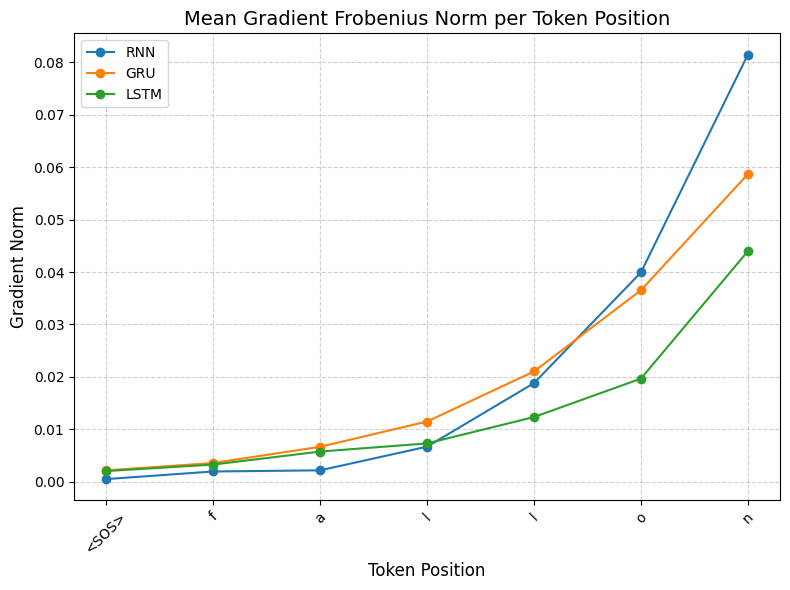

In [216]:
run_vanishing_gradient_pipeline(
    subset_loader=subset_loader,
    device=device,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    loss_type='gender',
    hidden_size=128,
    n_epochs=5
)

**Plot 1: loss_type='gender' (Gender classification)**
- **Task:** Predict gender from full name sequence.
- **Gradient trend:** Norms increase toward the end of the sequence.

**Interpretation:**
- Most gradient signal comes from the last characters — because the model only gets supervised feedback (loss) at the final output (after the full name).
- That’s why earlier tokens like <SOS>, f, a receive very small gradients — the signal "vanishes" as we move backward in time → vanishing gradient problem.
- RNN shows a sharper increase than GRU/LSTM, indicating worse vanishing.
- GRU and especially LSTM control gradient flow better — this is their core design strength (gates + memory cell).

Running gradient analysis for RNN...
Running gradient analysis for GRU...
Running gradient analysis for LSTM...


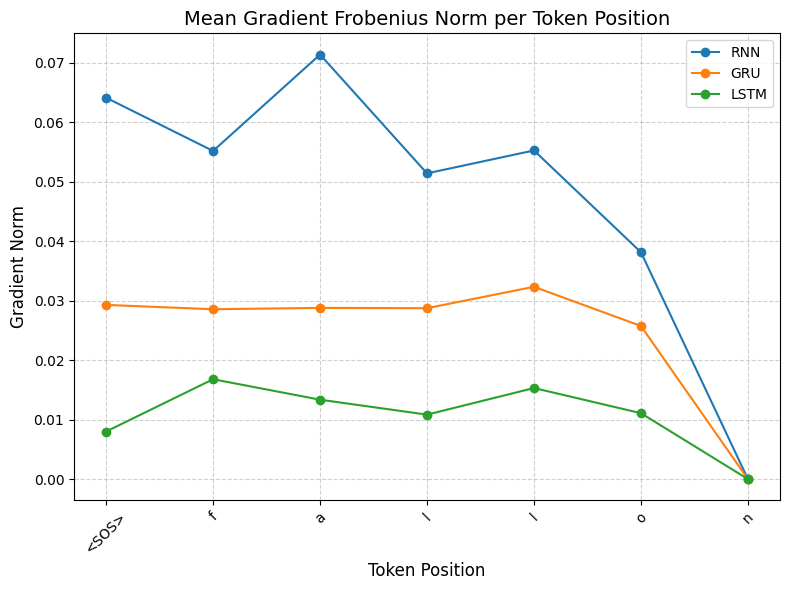

In [197]:
run_vanishing_gradient_pipeline(
    subset_loader=subset_loader,
    device=device,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    loss_type='next',
    hidden_size=128,
    n_epochs=5
)

**Plot 2: loss_type='next' (Next-letter prediction)**
- **Task:** Predict each next token from the previous one in the sequence.
- **Gradient trend:** No clear left-to-right decay; gradients are distributed more evenly across time steps.

**Interpretation:**

- The loss is applied at every position, so every token contributes to the gradient — even <SOS>, f, a, etc.

- No strong vanishing trend — early and middle positions get stronger gradients than in the gender task.

- However, LSTM still has lower gradients overall — possibly due to internal gates dampening updates, or slower convergence.

- RNN shows the highest gradients — possibly due to unstable updates (no gating mechanism).

**Key Takeaways**

| Observation         | Gender Task (`'gender'`)       | Next-Token Task (`'next'`)       |
|---------------------|-------------------------------|----------------------------------|
| Supervision position | Final output only              | All positions (seq-to-seq)       |
| Gradient flow        | Strong vanishing to the left   | More uniform                     |
| RNN                  | Strong vanishing               | High but unstable                |
| GRU                  | Better retention than RNN      | Stable                           |
| LSTM                 | Best retention, lower magnitude| Most stable, but conservative    |


**Why fixed-length names?**

To ensure:

- Gradient matrices have the same shape: (batch, seq_len, embedding_dim)
- Fair comparison across epochs and models (no padding inconsistencies)
- Proper alignment across token positions for averaging and plotting

### Multitask Learning

Test ROC AUC for Gender Prediction (CROSS ENTROPY Loss): 0.9223


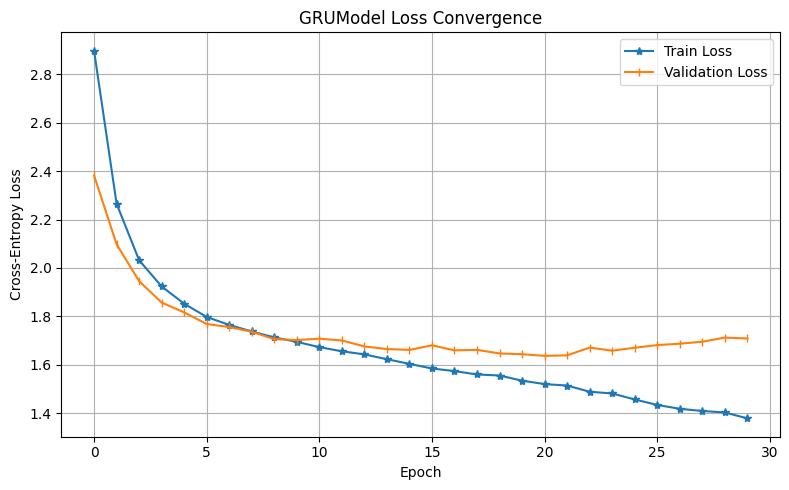

In [253]:
GRU = GRUModel(vocab_size, embedding_size, hidden_size).to(device)
train_losses, valid_losses = train_model(GRU, train_dataset, valid_dataset, vocab_size, loss_type='bce',
                                         num_epochs=30, batch_size=128, token_loss_weight=1.0, gender_loss_weight=1.0)
evaluate_gender_auc(GRU, test_dataset, batch_size=128, loss_type='CE', device=device)
plot_loss(GRU, train_losses, valid_losses)

In [259]:
for _ in range(10):
  print(generate_name(GRU, token2id, id2token, device=device).capitalize())

Cebla
Astanie
Arran
Aleone
Ina
Ariy
Elssa
Alamih
Atavun
Alberl


Test ROC AUC for Gender Prediction (CROSS ENTROPY Loss): 0.9203


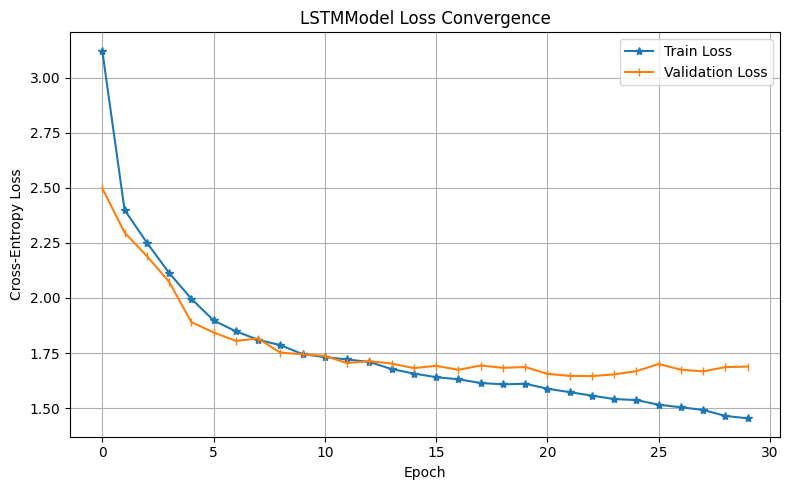

In [260]:
LSTM = LSTMModel(vocab_size, embedding_size, hidden_size).to(device)
train_losses, valid_losses = train_model(LSTM, train_dataset, valid_dataset, vocab_size, loss_type='bce',
                                         num_epochs=30, batch_size=128, token_loss_weight=1.0, gender_loss_weight=1.0)
evaluate_gender_auc(LSTM, test_dataset, batch_size=128, loss_type='CE', device=device)
plot_loss(LSTM, train_losses, valid_losses)

In [271]:
for _ in range(10):
  print(generate_name(LSTM, token2id, id2token, device=device).capitalize())

Ilen
Sahrine
Bruto
Arlia
Kalys
Ennan
Ialett
Losie
Laoje
Shaari


### Visualizing embeddings

In [272]:
def extract_embeddings(model):
    embedding_weights = model.embedding.weight.detach().cpu().numpy()
    return embedding_weights

def get_vowel_consonant_labels(id2token):
    vowels = set('aeiou')
    labels = []
    for i in range(len(id2token)):
      char = id2token.get(i, '')
      if char.isalpha():
        labels.append('vowel' if char.lower() in vowels else 'consonant')
      else:
        labels.append('other')
    return labels

def reduce_embeddings(embeddings):
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    pca = PCA(n_components=2)
    tsne_result = tsne.fit_transform(embeddings)
    pca_result = pca.fit_transform(embeddings)
    return tsne_result, pca_result

def plot_embedding_projection(ax, points, labels, id2token, title):
    colors = {'vowel': 'dodgerblue', 'consonant': 'orangered', 'other': 'gray'}

    for i, (x, y) in enumerate(points):
        label = labels[i]
        ax.scatter(x, y, c=colors[label], label=label if label not in ax.get_legend_handles_labels()[1] else "", alpha=0.8)
        ax.text(x + 0.01, y + 0.01, id2token.get(i, '?'), fontsize=8)

    ax.set_title(title, fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.6)

def visualize_embeddings(model, id2token):
    embeddings = extract_embeddings(model)
    labels = get_vowel_consonant_labels(id2token)
    tsne_result, pca_result = reduce_embeddings(embeddings)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    plot_embedding_projection(axes[0], tsne_result, labels, id2token, "TSNE Projection")
    plot_embedding_projection(axes[1], pca_result, labels, id2token, "PCA Projection")

    handles, names = axes[0].get_legend_handles_labels()
    fig.legend(handles, names, loc='upper center', ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
    plt.show()

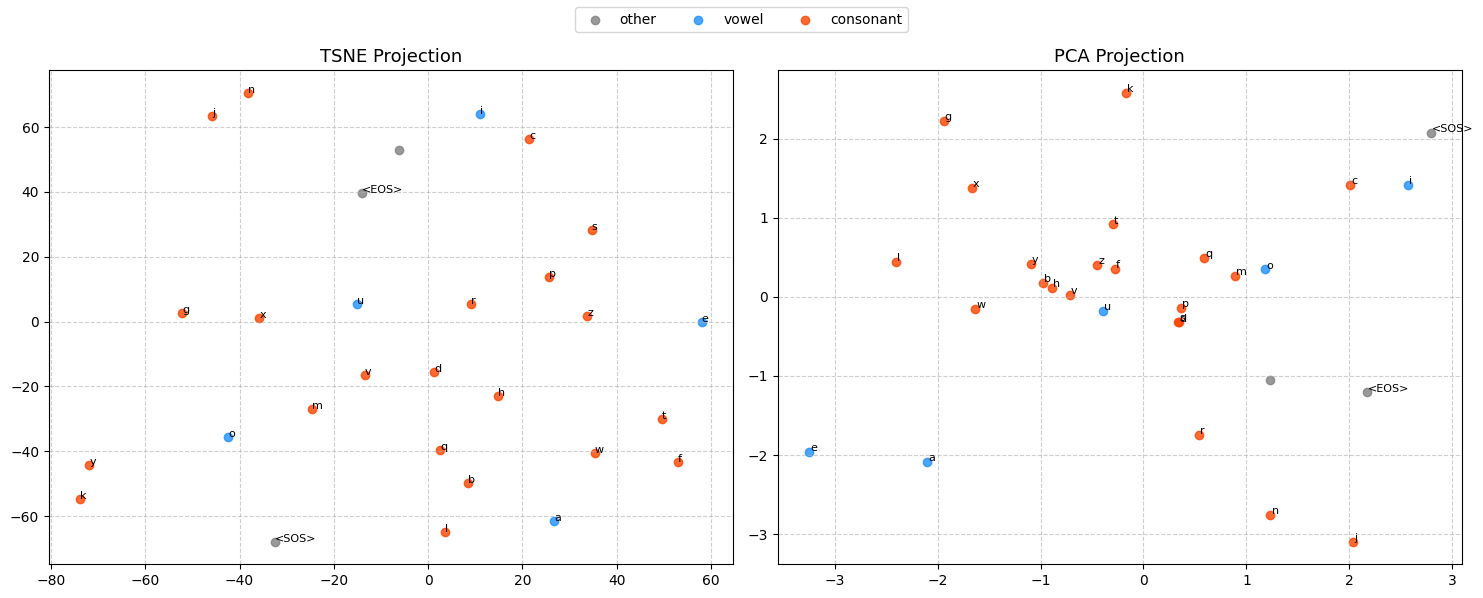

In [274]:
visualize_embeddings(GRU, id2token)

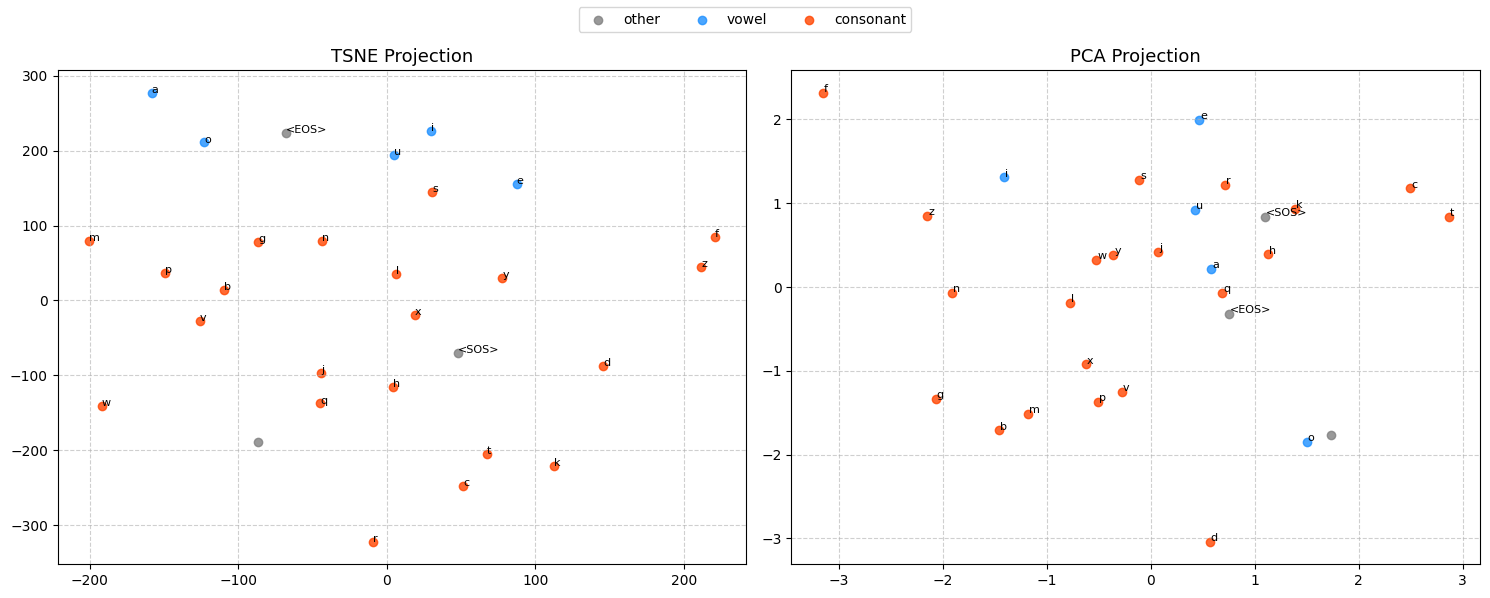

In [275]:
visualize_embeddings(LSTM, id2token)

Embeddings show clear separation between vowels and consonants. Special tokens `(<SOS>, <EOS>)` are isolated. Multitask training leads to structured, semantically meaningful embeddings. TSNE highlights local clusters, while PCA reveals global structure.

### Bonus Part

In [386]:
name_tensors = [torch.tensor(name, dtype=torch.long) for name in train_df['Encoded']]
gender_labels = np.array(train_df['Gender'])

In [387]:
def get_name_embedding(model, name_tensor):
    model.eval()
    with torch.no_grad():
      _, _, hidden = model(name_tensor.unsqueeze(0))  # Add batch dim: (1, seq_len)
      if isinstance(hidden, tuple):  # For LSTM: (hidden, cell)
        hidden = hidden[0]
      return hidden[-1].squeeze(0).cpu().numpy()  # shape: (hidden_dim,)

In [388]:
all_embeddings = []

for name_tensor in name_tensors:
  emb = get_name_embedding(GRU, name_tensor.to(device))
  all_embeddings.append(emb)

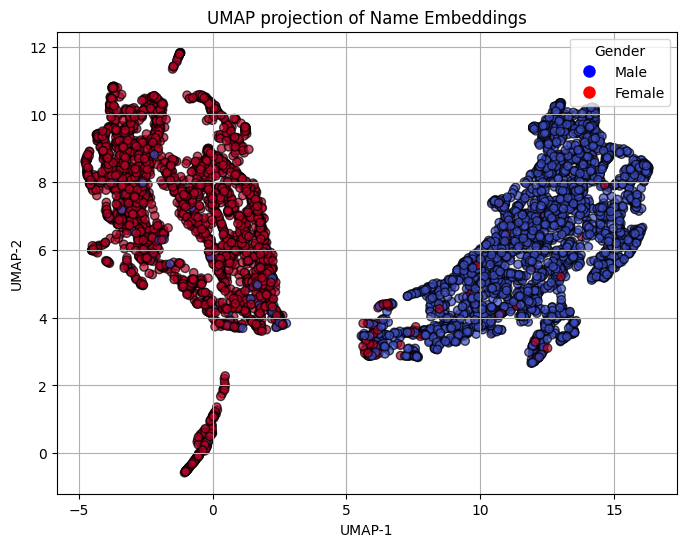

In [389]:
X = np.stack(all_embeddings)  # shape: (n_samples, hidden_dim)

reduced = UMAP(n_components=2).fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1],
                      c=gender_labels, cmap='coolwarm', alpha=0.7, edgecolor='k')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, title='Gender')

plt.title("UMAP projection of Name Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

In [390]:
X = np.stack(all_embeddings)
y = np.array(train_df['Gender'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [391]:
import lightgbm as lgb

model = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, verbosity=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.984124	valid_0's binary_logloss: 0.126936
ROC AUC: 0.9841


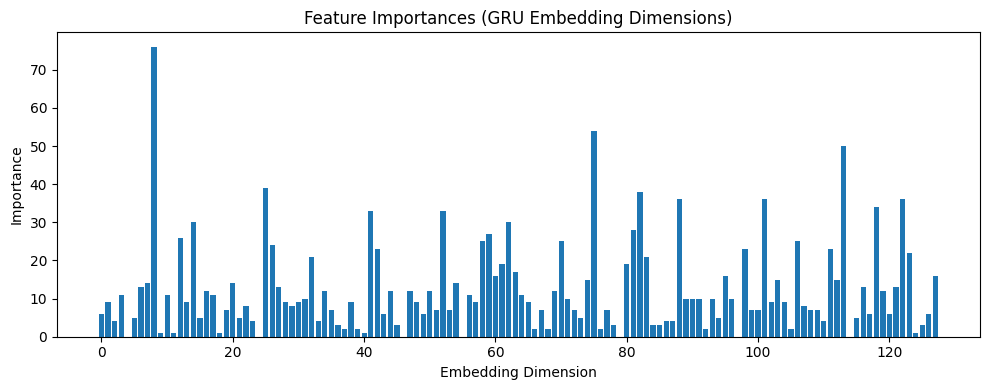

In [392]:
plt.figure(figsize=(10, 4))
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.title("Feature Importances (GRU Embedding Dimensions)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [414]:
class NameGenderDataset(Dataset):
    def __init__(self, name_tensors, labels):
        self.data = name_tensors
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = NameGenderDataset(name_tensors, gender_labels)

In [415]:
def collate_batch(batch):
    names, labels = zip(*batch)
    names = pad_sequence(names, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) for seq in names])
    return names, torch.tensor(labels), lengths

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)

In [416]:
class RNNClassifier(nn.Module):
    def __init__(self, rnn_type='GRU', vocab_size=..., embedding_dim=32, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_type = rnn_type

        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn = rnn_cls(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        embedded = self.embedding(x)  # [B, T, E]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed)
        if isinstance(hidden, tuple):  # LSTM
            hidden = hidden[0]
        return self.fc(hidden[-1]).squeeze(1)

In [417]:
def train_rnn_model(model, train_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        losses = []
        for x, y, lengths in train_loader:
          x, y, lengths = x.to(device), y.float().to(device), lengths.to(device)
          logits = model(x, lengths)
          loss = criterion(logits, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          losses.append(loss.item())
        print(f"Epoch {epoch+1}: Loss = {sum(losses)/len(losses):.4f}")

In [418]:
def evaluate_rnn_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
      for x, y, lengths in data_loader:
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)
        logits = model(x, lengths)
        probs = torch.sigmoid(logits)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    auc = roc_auc_score(all_labels, all_preds)
    print(f"ROC AUC: {auc:.4f}")
    return auc

In [421]:
for rnn_type in ['RNN', 'GRU', 'LSTM']:
    print(f"\nTraining {rnn_type} Model")
    model = RNNClassifier(rnn_type=rnn_type, vocab_size=len(token2id), embedding_dim=32, hidden_dim=64)
    train_rnn_model(model, train_loader, epochs=10)
    auc = evaluate_rnn_model(model, train_loader)


Training RNN Model
Epoch 1: Loss = 0.6310
Epoch 2: Loss = 0.5317
Epoch 3: Loss = 0.4736
Epoch 4: Loss = 0.4498
Epoch 5: Loss = 0.4364
Epoch 6: Loss = 0.4228
Epoch 7: Loss = 0.4165
Epoch 8: Loss = 0.4109
Epoch 9: Loss = 0.4017
Epoch 10: Loss = 0.4129
ROC AUC: 0.9091

Training GRU Model
Epoch 1: Loss = 0.6162
Epoch 2: Loss = 0.4664
Epoch 3: Loss = 0.4328
Epoch 4: Loss = 0.4244
Epoch 5: Loss = 0.4095
Epoch 6: Loss = 0.4032
Epoch 7: Loss = 0.3968
Epoch 8: Loss = 0.3826
Epoch 9: Loss = 0.3730
Epoch 10: Loss = 0.3689
ROC AUC: 0.9239

Training LSTM Model
Epoch 1: Loss = 0.6625
Epoch 2: Loss = 0.5014
Epoch 3: Loss = 0.4494
Epoch 4: Loss = 0.4228
Epoch 5: Loss = 0.4099
Epoch 6: Loss = 0.4009
Epoch 7: Loss = 0.3877
Epoch 8: Loss = 0.3774
Epoch 9: Loss = 0.3710
Epoch 10: Loss = 0.3625
ROC AUC: 0.9231
